<a href="https://colab.research.google.com/github/gokhanturer/JSL/blob/main/final_NER__model_me.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

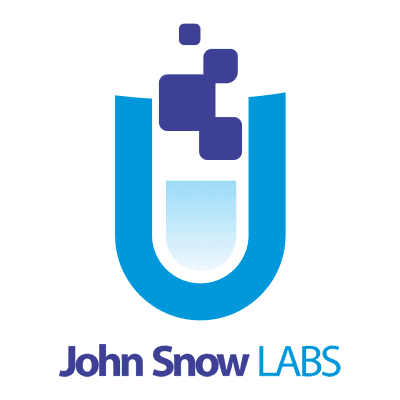

# Colab Setup

In [1]:
! pip install -q pyspark==3.1.2 spark-nlp

! pip install -q spark-nlp-display

     |████████████████████████████████| 212.4 MB 82 kB/s 
     |████████████████████████████████| 140 kB 61.0 MB/s 
     |████████████████████████████████| 198 kB 73.0 MB/s 
     |████████████████████████████████| 95 kB 2.0 MB/s 
     |████████████████████████████████| 66 kB 3.5 MB/s 


In [3]:
import sparknlp

spark = sparknlp.start(gpu = True) 

from sparknlp.base import *
from sparknlp.annotator import *
import pyspark.sql.functions as F
from sparknlp.training import CoNLL

print("Spark NLP version", sparknlp.version())

print("Apache Spark version:", spark.version)

spark

Spark NLP version 3.4.0
Apache Spark version: 3.1.2


# CONLL Data Prep

In [2]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/src/test/resources/conll2003/eng.train
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/src/test/resources/conll2003/eng.testa

### Train Data

In [5]:
with open ("eng.train") as f:
  train_data = f.read()
print (train_data[:500])

-DOCSTART- -X- -X- O

EU NNP B-NP B-ORG
rejects VBZ B-VP O
German JJ B-NP B-MISC
call NN I-NP O
to TO B-VP O
boycott VB I-VP O
British JJ B-NP B-MISC
lamb NN I-NP O
. . O O

Peter NNP B-NP B-PER
Blackburn NNP I-NP I-PER

BRUSSELS NNP B-NP B-LOC
1996-08-22 CD I-NP O

The DT B-NP O
European NNP I-NP B-ORG
Commission NNP I-NP I-ORG
said VBD B-VP O
on IN B-PP O
Thursday NNP B-NP O
it PRP B-NP O
disagreed VBD B-VP O
with IN B-PP O
German JJ B-NP B-MISC
advice NN I-NP O
to TO B-PP O
consumers NNS B-NP


In [6]:
train_data = CoNLL().readDataset(spark, 'eng.train')

train_data.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|                 pos|               label|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|EU rejects German...|[{document, 0, 47...|[{document, 0, 47...|[{token, 0, 1, EU...|[{pos, 0, 1, NNP,...|[{named_entity, 0...|
|     Peter Blackburn|[{document, 0, 14...|[{document, 0, 14...|[{token, 0, 4, Pe...|[{pos, 0, 4, NNP,...|[{named_entity, 0...|
| BRUSSELS 1996-08-22|[{document, 0, 18...|[{document, 0, 18...|[{token, 0, 7, BR...|[{pos, 0, 7, NNP,...|[{named_entity, 0...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



In [7]:
train_data.count()

14041

In [8]:
train_data.select(F.explode(F.arrays_zip('token.result', 'pos.result',  'label.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("pos"),
        F.expr("cols['2']").alias("ner_label")).show(truncate=50)

+----------+---+---------+
|     token|pos|ner_label|
+----------+---+---------+
|        EU|NNP|    B-ORG|
|   rejects|VBZ|        O|
|    German| JJ|   B-MISC|
|      call| NN|        O|
|        to| TO|        O|
|   boycott| VB|        O|
|   British| JJ|   B-MISC|
|      lamb| NN|        O|
|         .|  .|        O|
|     Peter|NNP|    B-PER|
| Blackburn|NNP|    I-PER|
|  BRUSSELS|NNP|    B-LOC|
|1996-08-22| CD|        O|
|       The| DT|        O|
|  European|NNP|    B-ORG|
|Commission|NNP|    I-ORG|
|      said|VBD|        O|
|        on| IN|        O|
|  Thursday|NNP|        O|
|        it|PRP|        O|
+----------+---+---------+
only showing top 20 rows



In [9]:
train_data.select(F.explode(F.arrays_zip("token.result","label.result")).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ground_truth")).groupBy("ground_truth").count().orderBy("count", ascending=False).show(100,truncate=False)

+------------+------+
|ground_truth|count |
+------------+------+
|O           |169578|
|B-LOC       |7140  |
|B-PER       |6600  |
|B-ORG       |6321  |
|I-PER       |4528  |
|I-ORG       |3704  |
|B-MISC      |3438  |
|I-LOC       |1157  |
|I-MISC      |1155  |
+------------+------+



In [10]:
#conll_data.select(F.countDistinct("label.result")).show()
#conll_data.groupBy("label.result").count().show(truncate=False)

train_data = train_data.withColumn('unique', F.array_distinct("label.result"))\
                       .withColumn('c', F.size('unique'))\
                       .filter(F.col('c')>1)

train_data.select(F.explode(F.arrays_zip('token.result','label.result')).alias("cols")) \
          .select(F.expr("cols['0']").alias("token"),
                  F.expr("cols['1']").alias("ground_truth"))\
          .groupBy('ground_truth')\
          .count()\
          .orderBy('count', ascending=False)\
          .show(100,truncate=False)

+------------+------+
|ground_truth|count |
+------------+------+
|O           |137736|
|B-LOC       |7125  |
|B-PER       |6596  |
|B-ORG       |6288  |
|I-PER       |4528  |
|I-ORG       |3704  |
|B-MISC      |3437  |
|I-LOC       |1157  |
|I-MISC      |1155  |
+------------+------+



### Test Data

In [11]:
with open ("eng.testa") as f:
  test_data = f.read()
print (test_data[:500])

-DOCSTART- -X- -X- O

CRICKET NNP B-NP O
- : O O
LEICESTERSHIRE NNP B-NP B-ORG
TAKE NNP I-NP O
OVER IN B-PP O
AT NNP B-NP O
TOP NNP I-NP O
AFTER NNP I-NP O
INNINGS NNP I-NP O
VICTORY NN I-NP O
. . O O

LONDON NNP B-NP B-LOC
1996-08-30 CD I-NP O

West NNP B-NP B-MISC
Indian NNP I-NP I-MISC
all-rounder NN I-NP O
Phil NNP I-NP B-PER
Simmons NNP I-NP I-PER
took VBD B-VP O
four CD B-NP O
for IN B-PP O
38 CD B-NP O
on IN B-PP O
Friday NNP B-NP O
as IN B-PP O
Leicestershire NNP B-NP B-ORG
beat VBD B-VP


In [12]:
test_data = CoNLL().readDataset(spark, 'eng.testa')
test_data.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|                 pos|               label|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|CRICKET - LEICEST...|[{document, 0, 64...|[{document, 0, 64...|[{token, 0, 6, CR...|[{pos, 0, 6, NNP,...|[{named_entity, 0...|
|   LONDON 1996-08-30|[{document, 0, 16...|[{document, 0, 16...|[{token, 0, 5, LO...|[{pos, 0, 5, NNP,...|[{named_entity, 0...|
|West Indian all-r...|[{document, 0, 18...|[{document, 0, 18...|[{token, 0, 3, We...|[{pos, 0, 3, NNP,...|[{named_entity, 0...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



In [13]:
test_data.count()

3250

In [14]:
test_data.select(F.explode(F.arrays_zip("token.result","label.result")).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ground_truth")).groupBy("ground_truth").count().orderBy("count", ascending=False).show(100,truncate=False)

+------------+-----+
|ground_truth|count|
+------------+-----+
|O           |42759|
|B-PER       |1842 |
|B-LOC       |1837 |
|B-ORG       |1341 |
|I-PER       |1307 |
|B-MISC      |922  |
|I-ORG       |751  |
|I-MISC      |346  |
|I-LOC       |257  |
+------------+-----+



# NERDL Model with Glove_100d

In [15]:
glove_embeddings = WordEmbeddingsModel.pretrained()\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


In [16]:
glove_embeddings.transform(test_data).write.parquet('test_data_embeddings.parquet')

In [17]:
nerTagger = NerDLApproach()\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setLabelColumn("label")\
    .setOutputCol("ner")\
    .setMaxEpochs(8)\
    .setLr(0.002)\
    .setDropout(0.5)\
    .setBatchSize(16)\
    .setRandomSeed(0)\
    .setVerbose(1)\
    .setEvaluationLogExtended(True) \
    .setEnableOutputLogs(True)\
    .setIncludeConfidence(True)\
    .setTestDataset('test_data_embeddings.parquet')\
    .setEnableMemoryOptimizer(False)

ner_pipeline = Pipeline(stages=[
      glove_embeddings,
      nerTagger
])

In [19]:
%%time

ner_model = ner_pipeline.fit(train_data)

CPU times: user 10.6 s, sys: 1.08 s, total: 11.7 s
Wall time: 35min 21s


In [20]:
!cd ~/annotator_logs/ && ls -lt

total 16
-rw-r--r-- 1 root root 13178 Feb  6 17:05 NerDLApproach_c5bf4e4c6211.log


In [21]:
!cat ~/annotator_logs/NerDLApproach_c5bf4e4c6211.log

Name of the selected graph: ner-dl/blstm_10_100_128_120.pb
Training started - total epochs: 8 - lr: 0.002 - batch size: 16 - labels: 9 - chars: 82 - training examples: 11079


Epoch 1/8 started, lr: 0.002, dataset size: 11079


Epoch 1/8 - 159.93s - loss: 2234.436 - batches: 695
Quality on test dataset: 
time to finish evaluation: 17.74s
label	 tp	 fp	 fn	 prec	 rec	 f1
B-LOC	 1695	 94	 142	 0.94745666	 0.92270005	 0.93491447
I-ORG	 528	 76	 223	 0.8741722	 0.7030626	 0.77933586
I-MISC	 255	 88	 91	 0.7434402	 0.7369942	 0.74020314
I-LOC	 189	 14	 68	 0.9310345	 0.73540854	 0.8217391
I-PER	 1270	 59	 37	 0.95560575	 0.9716909	 0.9635812
B-MISC	 797	 142	 125	 0.84877527	 0.8644252	 0.85652876
B-ORG	 1139	 170	 202	 0.8701299	 0.8493661	 0.85962266
B-PER	 1802	 176	 40	 0.91102123	 0.9782845	 0.94345546
tp: 7675 fp: 819 fn: 928 labels: 8
Macro-average	 prec: 0.8852045, rec: 0.84524155, f1: 0.86476153
Micro-average	 prec: 0.903579, rec: 0.8921307, f1: 0.8978184


Epoch 2/8 started, lr: 0

In [22]:
import pyspark.sql.functions as F

predictions = ner_model.transform(test_data)

predictions.select(F.explode(F.arrays_zip('token.result','label.result','ner.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ground_truth"),
        F.expr("cols['2']").alias("prediction")).show(truncate=False)

+--------------+------------+----------+
|token         |ground_truth|prediction|
+--------------+------------+----------+
|CRICKET       |O           |O         |
|-             |O           |O         |
|LEICESTERSHIRE|B-ORG       |B-ORG     |
|TAKE          |O           |O         |
|OVER          |O           |O         |
|AT            |O           |O         |
|TOP           |O           |O         |
|AFTER         |O           |O         |
|INNINGS       |O           |O         |
|VICTORY       |O           |O         |
|.             |O           |O         |
|LONDON        |B-LOC       |B-LOC     |
|1996-08-30    |O           |O         |
|West          |B-MISC      |B-MISC    |
|Indian        |I-MISC      |I-MISC    |
|all-rounder   |O           |O         |
|Phil          |B-PER       |B-PER     |
|Simmons       |I-PER       |I-PER     |
|took          |O           |O         |
|four          |O           |O         |
+--------------+------------+----------+
only showing top

In [23]:
from sklearn.metrics import classification_report

preds_df = predictions.select(F.explode(F.arrays_zip('token.result','label.result','ner.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ground_truth"),
        F.expr("cols['2']").alias("prediction")).toPandas()

print (classification_report(preds_df['ground_truth'], preds_df['prediction']))

              precision    recall  f1-score   support

       B-LOC       0.97      0.95      0.96      1837
      B-MISC       0.88      0.90      0.89       922
       B-ORG       0.90      0.94      0.92      1341
       B-PER       0.96      0.98      0.97      1842
       I-LOC       0.96      0.87      0.91       257
      I-MISC       0.86      0.78      0.82       346
       I-ORG       0.90      0.90      0.90       751
       I-PER       0.97      0.97      0.97      1307
           O       1.00      1.00      1.00     42759

    accuracy                           0.99     51362
   macro avg       0.93      0.92      0.93     51362
weighted avg       0.99      0.99      0.99     51362



### Saving the Trained Model

In [24]:
ner_model.stages

[WORD_EMBEDDINGS_MODEL_48cffc8b9a76, NerDLModel_6a88a8ead3fd]

In [25]:
ner_model.stages[1].write().overwrite().save("/content/drive/MyDrive/SparkNLPTask/Ner_glove_100d_e8_b16_lr0.02")

# Prediction Pipeline

In [28]:
document = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentence = SentenceDetector()\
    .setInputCols(['document'])\
    .setOutputCol('sentence')

token = Tokenizer()\
    .setInputCols(['sentence'])\
    .setOutputCol('token')
    
glove_embeddings = WordEmbeddingsModel.pretrained()\
    .setInputCols(["document", "token"])\
    .setOutputCol("embeddings")

loaded_ner_model = NerDLModel.load("/content/drive/MyDrive/SparkNLPTask/Ner_glove_100d_e8_b16_lr0.02")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner")

converter = NerConverter()\
    .setInputCols(["sentence", "token", "ner"])\
    .setOutputCol("ner_span")

ner_prediction_pipeline = Pipeline(stages = [
      document,
      sentence,
      token,
      glove_embeddings,
      loaded_ner_model,
      converter
  ])

empty_data = spark.createDataFrame([['']]).toDF("text")

prediction_model = ner_prediction_pipeline.fit(empty_data)

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


In [33]:
text = '''
The final has its own Merseyside subplot, as it will pit Liverpool forwards Mo Salah (of Egypt: pictured above, in white, in the semi-final) and Sadio Mané (of Senegal) against each other. They are just two of the African stars to play for European clubs—the world’s strongest. In fact, only four teams in the English Premier League don’t have a player from the continent. Besides Mr Salah and Mr Mané, Riyad Mahrez of Algeria is at Manchester City, Wilfred Ndidi of Nigeria and Chelsea boasts Edouard Mendy, Senegal’s goalkeeper, and Hakim Ziyech of Morocco. In Italy’s Serie A, Kalidou Koulibaly of Senegal plays for Napoli and Franck Kessie of the Ivory Coast turns out for AC Milan. Eric Maxim Choupo-Moting of Cameroon and Bouna Sarr of Senegal both play for Bayern Munich, the dominant club in Germany’s Bundesliga.
'''

sample_data = spark.createDataFrame([[text]]).toDF("text")

sample_data.show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                                                         

In [34]:
preds = prediction_model.transform(sample_data)

result_df = preds.select(F.explode(F.arrays_zip("ner_span.result","ner_span.metadata")).alias("entities")) \
                .select(F.expr("entities['0']").alias("chunk"),
                        F.expr("entities['1'].entity").alias("entity")).show(truncate=False)

+---------------+------+
|chunk          |entity|
+---------------+------+
|Merseyside     |ORG   |
|Liverpool      |ORG   |
|Mo Salah       |PER   |
|Egypt          |LOC   |
|Sadio Mané     |PER   |
|Senegal        |LOC   |
|African        |MISC  |
|European       |MISC  |
|English        |MISC  |
|Premier League |ORG   |
|Mr Salah       |PER   |
|Mr Mané        |PER   |
|Riyad Mahrez   |PER   |
|Algeria        |LOC   |
|Manchester City|LOC   |
|Wilfred Ndidi  |PER   |
|Nigeria        |LOC   |
|Chelsea        |ORG   |
|Edouard Mendy  |PER   |
|Senegal’s      |PER   |
+---------------+------+
only showing top 20 rows



In [35]:
from sparknlp.base import LightPipeline

light_model = LightPipeline(prediction_model)

result = light_model.annotate(text)

list(zip(result['token'], result['ner']))

[('The', 'O'),
 ('final', 'O'),
 ('has', 'O'),
 ('its', 'O'),
 ('own', 'O'),
 ('Merseyside', 'B-ORG'),
 ('subplot', 'O'),
 (',', 'O'),
 ('as', 'O'),
 ('it', 'O'),
 ('will', 'O'),
 ('pit', 'O'),
 ('Liverpool', 'B-ORG'),
 ('forwards', 'O'),
 ('Mo', 'B-PER'),
 ('Salah', 'I-PER'),
 ('(', 'O'),
 ('of', 'O'),
 ('Egypt', 'B-LOC'),
 (':', 'O'),
 ('pictured', 'O'),
 ('above', 'O'),
 (',', 'O'),
 ('in', 'O'),
 ('white', 'O'),
 (',', 'O'),
 ('in', 'O'),
 ('the', 'O'),
 ('semi-final', 'O'),
 (')', 'O'),
 ('and', 'O'),
 ('Sadio', 'B-PER'),
 ('Mané', 'I-PER'),
 ('(', 'O'),
 ('of', 'O'),
 ('Senegal', 'B-LOC'),
 (')', 'O'),
 ('against', 'O'),
 ('each', 'O'),
 ('other', 'O'),
 ('.', 'O'),
 ('They', 'O'),
 ('are', 'O'),
 ('just', 'O'),
 ('two', 'O'),
 ('of', 'O'),
 ('the', 'O'),
 ('African', 'B-MISC'),
 ('stars', 'O'),
 ('to', 'O'),
 ('play', 'O'),
 ('for', 'O'),
 ('European', 'B-MISC'),
 ('clubs—the', 'O'),
 ('world’s', 'O'),
 ('strongest', 'O'),
 ('.', 'O'),
 ('In', 'O'),
 ('fact', 'O'),
 (',', 'O'),


In [37]:
import pandas as pd

result = light_model.fullAnnotate(text)

ner_df= pd.DataFrame([(int(x.metadata['sentence']), x.result, x.begin, x.end, y.result) for x,y in zip(result[0]["token"], result[0]["ner"])], 
                      columns=['sent_id','token','start','end','ner'])
ner_df.head(15)

,sent_id,token,start,end,ner
0,0,The,1,3,O
1,0,final,5,9,O
2,0,has,11,13,O
3,0,its,15,17,O
4,0,own,19,21,O
5,0,Merseyside,23,32,B-ORG
6,0,subplot,34,40,O
7,0,",",41,41,O
8,0,as,43,44,O
9,0,it,46,47,O


### Highlight Entities

In [38]:
ann_text = light_model.fullAnnotate(text)[0]
ann_text.keys()

dict_keys(['document', 'ner_span', 'token', 'ner', 'embeddings', 'sentence'])

In [39]:
from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()
print ('Standard Output')
visualiser.display(ann_text, label_col='ner_span', document_col='document')

Standard Output


# Streamlit

In [14]:
! pip install -q pyspark==3.1.2 spark-nlp

! pip install -q spark-nlp-display

In [ ]:
!pip install streamlit

!pip install pyngrok==4.1.1

In [2]:
! wget https://raw.githubusercontent.com/gokhanturer/JSL/main/streamlit_me_ner_model.py

--2022-02-06 22:39:33--  https://raw.githubusercontent.com/gokhanturer/JSL/main/streamlit_me_ner_model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7979 (7.8K) [text/plain]
Saving to: ‘streamlit_me_ner_model.py.3’

streamlit_me_ner_mo 100%[===================>]   7.79K  --.-KB/s    in 0s      

2022-02-06 22:39:34 (93.4 MB/s) - ‘streamlit_me_ner_model.py.3’ saved [7979/7979]



In [3]:
!ngrok authtoken 24jtZ2Watn1mc1bSG6v19fel7p1_2bYeRjRkniKqqhfgRs6ub

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [5]:
!streamlit run streamlit_me_ner_model.py &>/dev/null&

In [6]:
from pyngrok import ngrok

public_url = ngrok.connect(port='8501')
public_url

'http://2d54-34-125-109-11.ngrok.io'

In [7]:
!killall ngrok

public_url = ngrok.connect(port='8501')
public_url

'http://df30-34-125-109-11.ngrok.io'